In [34]:
import sys, numpy as np
from keras.datasets import mnist
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

In [19]:
#loading the mnist data into train and test sets

(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [20]:
images, labels = (x_train[0:1000].reshape(1000,28*28)/255, y_train[0:1000])

In [21]:
#one hot encoding

one_hot_labels = np.zeros((len(labels), 10))
for i,l in enumerate(labels):
  one_hot_labels[i][l] = 1
labels = one_hot_labels

In [35]:
test_images = x_test.reshape(len(x_test), 28*28)/255
y_test = to_categorical(y_test[0:10000], num_classes=10)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


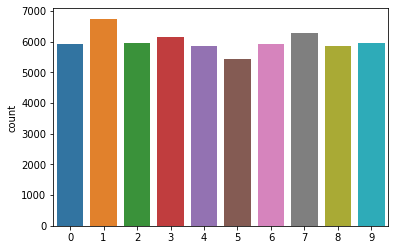

In [7]:
"g = sns.countplot(y_train)

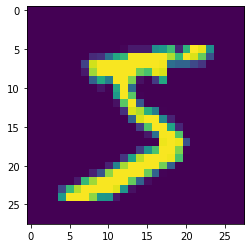

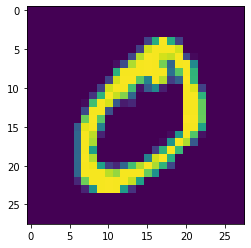

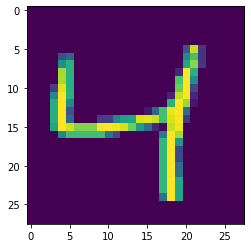

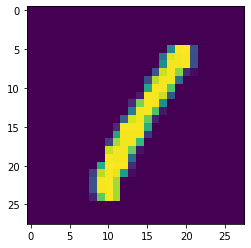

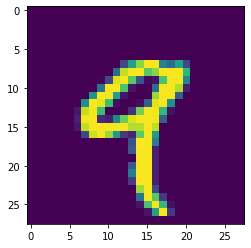

In [8]:
#visualizations of the digits in mnist

for i in range (0,5):
  plt.imshow(x_train[i])
  plt.show()

In [23]:
#reshaping train into 3 dimensions 

reshaped_x_train = x_train.reshape(-1,28,28,1)

In [37]:
#Data augmentation to supplement the training data

datagen = ImageDataGenerator(featurewise_center=False,
                             samplewise_center=False,
                             featurewise_std_normalization=False,
                             samplewise_std_normalization=False,
                             zca_whitening=False,
                             rotation_range=10,
                             zoom_range=0.1,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             horizontal_flip=False,
                             vertical_flip=False
                             )

datagen.fit(reshaped_x_train)

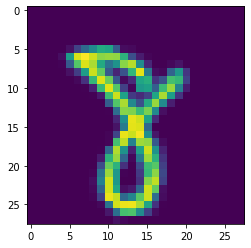

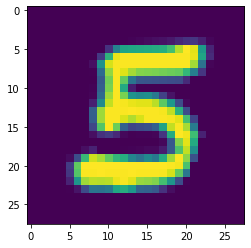

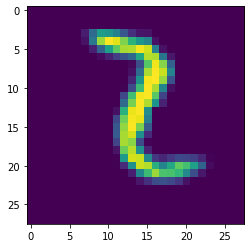

In [40]:
for x_augmented, y_augmented in datagen.flow(reshaped_x_train, y_train, batch_size=9):
  for i in range (0, 3):
    plt.imshow(x_augmented[i].reshape(28, 28))
    plt.show()
  break

##**Defining the model along with other necessary functions**

##**Dropout**

In [5]:
def Dropout(self, activations, dropout_prob=0.5):
  #sets half of the activations to zero, takes parameters (activations, numpy array), returns (activations, which half set to zero)
  #handle error
  if dropout_prob < 0 or dropout_prob > 1:
    dropout_prob = 0.5
  
  #scale the activations
  activations /= dropout_prob
  mult = np.random.binomal(1, dropout_prob, size=activations.shape)
  activations *= mult
  return activations

##**Loss Function**

In [2]:
class MSE:
  def __call__(self, y_pred, y_true):
    self.y_pred = y_pred
    self.y_true = y_true
    return ((y_pred - y_true) ** 2).mean()
  
  def backward(self):
    n = self.y_true.shape[0]
    self.gradient = 2. * (self.y_pred - self.y_true) / n
    print('MSE backward', self.y_pred.shape, self.y_true.shape, self.gradient.shape)
    return self.gradient

#**Linear class**

In [3]:
class Linear:
  def __init__(self, input_dim: int, num_hidden: int = 1):
    self.weights = np.random.randn(input_dim, num_hidden) * np.sqrt(2. / input_dim)
    self.bias = np.zeros(num_hidden)

  def __call__(self, x):
    self.x = x
    output = x @ self.weights + self.bias
    return output
  
  def backward(self, gradient):
    self.weights_gradient = self.x.T @ gradient
    self.bias_gradient = gradient.sum(axis=0)
    self.x_gradient = gradient @ self.weights.T
    return self.x_gradient
  
  def update(self, lr):
    self.weights = self.weights - lr * self.weights_gradient
    self.bias = self.bias - lr * self.bias_gradient

##**ReLU activation layer**

In [4]:
class Relu:
  def __call__(self, input_):
    self.input_ = input_
    self.output = np.clip(self.input_, 0, None)
    return self.output
  
  def backward(self, output_gradient):
    self.input_gradient = (self.input_ > 0) * output_gradient
    return self.input_gradient

##**Defining model class**

In [6]:
#Building a 3 Layer Neural Network model. Choosing 512 neurons as the hidden layer neurons. Output is 10

class Model:
  def __init__(self, input_dim, num_hidden):
    self.linear1 = Linear(input_dim, num_hidden)
    self.relu1 = Relu()
    self.dropout1 = Dropout(0.45)
    self.linear2 = Linear(num_hidden, 512)
    self.relu2 = Relu()
    self.dropout2 = Dropout(0.35)
    self.linear3 = Linear(128, 10)
  
  def __call__(self, x):
    l1 = self.linear1(x)
    r1 = self.relu1(l1)
    if training:
      r1 = self.dropout1(r1)
    l2 = self.linear2(r1)
    r2 = self.relu2(l2)
    if training:
      r2 = self.dropout2(r2)
    l3 = self.linear3(r2)
    return l3
  
  def backward(self, output_gradient):
    linear3_gradient = self.linear3.backward(output_gradient)
    relu2_gradient = self.relu2.backward(linear3_gradient)
    linear2_gradient = self.linear2.backward(relu2_gradient)

    #dropout
    linear2_gradient = self.dropout2(linear2_gradient)
    relu1_gradient = self.relu1.backward(linear2_gradient)
    linear1_gradient = self.linear1.backward(relu1_gradient)

    #dropout
    linear1_gradient = self.dropout1(linear1_gradient)
    return linear1_gradient
  
  def update(self, lr):
    self.linear3.update(lr)
    self.linear2.update(lr)
    self.linear1.update(lr)

In [60]:
from typing import Callable

def fit(x_train: np.ndarray, y_train: np.ndarray, x_test: np.ndarray,
        y_test: np.ndarray, model: Callable, loss: Callable,
        learning_rate: float, num_epochs: int, batch_size=1):
  train_loss, train_acc, test_loss, test_acc = [], [], [], []
    
  for epoch in range(num_epochs):  
    for i in range(int(len(x_train)/batch_size)):
      batch_start, batch_end = ((i * batch_size), ((i+1) * batch_size))

      y_pred = model(x_train[batch_start:batch_end])
      loss_value = loss(y_pred, y_train[batch_start:batch_end])
      gradient_from_loss = loss.backward()
      model = model.backward(gradient_from_loss)
      model = model.update(lr)

      
    if epoch % 100 == 0:
      print('Epoch', epoch)
      train_error = loss(y_train, y_pred)
      train_accuracy = accuracy_score(y_train, y_pred)
      print('Train Loss {train_error}, Train Accuracy {train_accuracy')

      train_loss.append(train_error)
      train_acc.append(train_accuracy)

      test_error = loss(y_test, y_pred)
      test_accuracy = accuracy_score(y_test, y_pred)
      print('Test Loss {test_error}, Train Accuracy {test_accuracy')

      test_loss.append(test_error)
      test_acc.append(test_accuracy)

  return train_loss, train_acc, test_loss, test_acc
         

In [61]:
loss = MSE()
model = Model(784, 512)
train_acc, test_acc, test_loss, test_acc = fit(x_augmented, y_augmented, test_images, y_test,
                          model=model, loss=loss, learning_rate=0.02, num_epochs=50, 
                          batch_size=100)

Epoch 0


UnboundLocalError: ignored